In [1]:
# Imports usados para a simulação
import numpy as np
from matplotlib import pyplot as plt

# Testes para verificação da lei dos grandes números

Este notebook é dedicada para a elaboração de testes e diferentes averiguações da lei dos grandes números e da propriedade da equipartição assintótica (AEP). Dessa forma, busca-se analisar o caráter aleatório de diversos aspectos da teoria da informação

## Verificação da LGN

Neste segmento, verifica-se que, para grandes números, ou seja $n \to \infty$, verificam-se tanto a lei forte dos grandes números. Ao considerar um determinado evento $X$:

\begin{align}
    &\lim_{n \to \infty} \sum_{x \in X} \frac{x}{n} = \bar{X} = E\{X\} \\
    &\lim_{n \to \infty} P(\bar{X} = E\{X\}) = 1
\end{align}

Com o operador $E\{X\} = \sum_{x \in X} x P(x)$.

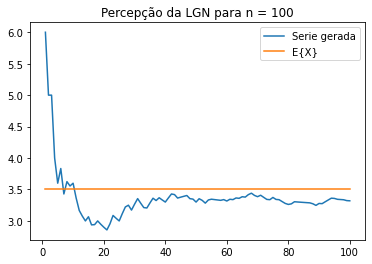

In [6]:
# Função de média ao longo de um vetor
def LGN_izer (vec):
    '''Função de observação do comportamento assintótico
       de uma determinada série temporal para fins de
       exploração'''
    return np.array(
        [np.sum(vec[:(ii + 1)]) / (ii + 1) for ii, _ in enumerate(vec)]
    )

# Inicializa o tamanho da simulação e seus limites
n = 100
lo_lim = 1
hi_lim = 6
r_vec = np.arange(lo_lim, hi_lim+1)
p = np.array([1/len(r_vec) for ii in range(len(r_vec))])

# Calcula série temporal e sua média aritmética
int_vec = np.random.choice(r_vec, size=n, p=p)
mu_hat = sum([pp * ii for ii, pp in zip(r_vec, p)])

# Faz média ensamble por cada passo
mu_vec = np.zeros(int_vec.shape)
sum_tmp = 0
for ii, val in enumerate(int_vec):
    sum_tmp += val
    mu_vec[ii] = sum_tmp/ (ii + 1)

# Cria vetor de eixo de tempo para a plotagem
t = list(range(1, n+1))
    
# Plota valores obtidos
plt.plot(t, mu_vec, label="Serie gerada")
plt.plot(t, mu_hat * np.ones((n)), label="E{X}")
plt.legend()
plt.title(f"Percepção da LGN para n = {n}")
plt.show()

## Avaliação da LGN para corrida de cavalos

Supondo uma determinada corrida com PMF: 
\begin{equation}
p = \begin{bmatrix}
    \frac{1}{2} & \frac{1}{4} & \frac{1}{8} & \frac{1}{8}
    \end{bmatrix}
\end{equation}

Quer-se avaliar, pela estratégia de máxima taxa de duplicação, qual o patrimônio acumulado em $n$ corridas e 
compará-lo com os valores reais simulados. Sabe-se que os prêmios nesse cenário são todos 4 para 1 e que:

\begin{equation}
    W^* = \sum_{i=1}^n p_i \log_2(b_i o_i)
\end{equation}

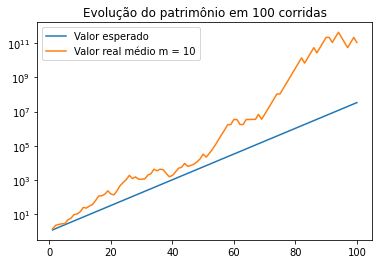

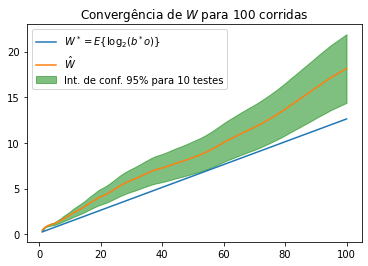

In [33]:
# Declaração de instância de simulações paralelas
m = 10

# Declaração de PMF e vetor de "odds".
p = np.array([1/2, 1/4, 1/8, 1/8])
#p = np.array([0.999, 0.0005, 0.0003, 0.0002])
o = np.array([4. for ii in range(4)])
b_star = p
b      = b_star
#b = np.array([1/4, 1/4,1/4, 1/4])
S_0 = 1. # Patrimônio inicial

# Cálculo de W*
W_star  = sum(pi * np.log2(bi * oi) for pi, (bi, oi) in zip(p, zip(b_star, o)))
opt_vec = np.power(S_0 * 2. * np.ones(n), W_star * np.float64(t))

# Cálculo da série temporal de resultados da corrida
S_vec = np.zeros((n, m))
for jj in range(m):
    W_hat = np.random.choice(4, size=n, p=p)
    for ii, val in enumerate(W_hat):
        if ii == 0:
            S_vec[ii, jj] = S_0 * (o[val] * b[val])
        else:
            S_vec[ii, jj] = S_vec[ii-1, jj] * (o[val] * b[val])

# Impressão e cálculo de estatísticas de controle de simulação
diff = S_vec - np.matmul(opt_vec, np.ones(S_vec.shape))
diff = np.abs(diff)
sigma_vec = np.std(
    diff, #S_vec
    axis=1
)
mu_vec = np.mean(
    S_vec, 
    axis=1
)
            
# Plotagem das variáveis obtidas
plt.plot(t, opt_vec, label="Valor esperado")
plt.legend()
plt.semilogy()
plt.plot(t, mu_vec, label=f"Valor real médio m = {m}")
plt.legend()
plt.title(f"Evolução do patrimônio em {n} corridas")
plt.show()

# Plotagem de W* e W_hat
W_opt  = LGN_izer(np.log2(opt_vec) / S_0)
W_hat  = LGN_izer(np.log2(mu_vec)  / S_0)

# Criação de variáveis de validação estatística
sig = np.log2(sigma_vec)
sig = LGN_izer(sig)
int_conf_sup = W_hat + 1.960*(sig / m)    # Intervalo de confiança de 95%
int_conf_inf = W_hat - 1.960*(sig / m)

plt.plot(t, W_opt, label=r"$W^* = E\{ \log_2(b^* o) \}$")
plt.plot(t, W_hat, label=r"$\hat{W}$")
plt.fill_between(
    t, 
    int_conf_inf, 
    int_conf_sup, 
    color="g", 
    alpha=0.5, 
    label=f"Int. de conf. 95% para {m} testes"
)
plt.title(f"Convergência de $W$ para {n} corridas")
plt.legend()
plt.show()

## Propriedade da Equipartição Assintótica (AEP)

Agora serão simulados os aspectos assintóticos da AEP. Sabe-se por Shannon que, para uma determinada fonte com estatística conhecida, existe um conjunto de sequências típicas $A_{\epsilon}^n$ com tamanho $n$ que todas as sequências desse conjunto são aproximadamente equiprováveis:

\begin{align}
    \lim_{n \to \infty} P(X_1, \dots, X_n) &= 2^{n H(X)} \\
    P(\{X_1, \dots,X_n\} \in A_{\epsilon}^n) &= 1 - \epsilon 
\end{align}

Sabe-se ainda que, dada uma tolerância $\epsilon$ associada a um determinado comprimento de sequência, pode-se modelar a probabilidade da sequência como um todo a partir da cota:

\begin{equation}
    2^{-n (H(X) + \epsilon)} \le P(X_1, \dots, X_n) \le 2^{-n (H(X) - \epsilon)}
\end{equation}

Para tanto, testaremos algumas métricas de problemas aleatórios com estatísticas conhecida de forma análoga ao experimento de corrida de cavalos e serão avaliadas métricas como a entropia, e o valor de epsilon para determinadas séries temporais.

### Cálculo do intervalo $\epsilon$

Para compreender o comportamento assintótico da AEP, para uma dada sequência $X^n$ de comprimento $n$, supondo que, dentro de um conjunto de $m$ simulações, todas as mensagens obtidas pertençam ao conjunto de sequências típicas, ou seja: $\{X^n_1, X^n_2, \dots, X^n_m\} \in A_\epsilon^n$, calcula-se o $\epsilon$ suficiente para que a condição seja estabelecida. Os valores da tolerância são calculados seguindo as equações abaixo.

\begin{align}
    \epsilon &= \max (p^+, p^-) \\
    p^+ &= \left| \frac{-\log_2(\gamma)}{n} - H(X) \right| \\
    p^- &= \left| \frac{-\log_2(\gamma)}{n} + H(X) \right| \\
    \gamma &= \left|P(X^n) - 2^{-n H(X)} \right|
\end{align}

eps = 0.24698134406010286


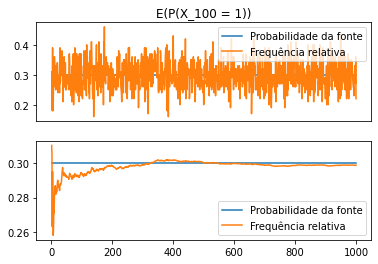

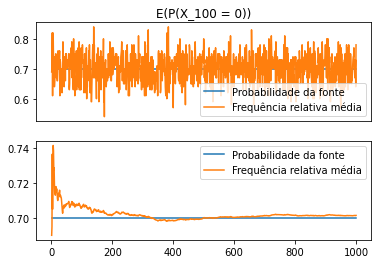

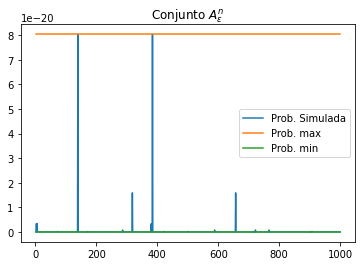

In [4]:
def entropy (p):
    '''Função de determinação da entropia de uma determinada
       distribuição de probabilidades p'''
    
    return np.sum([pp * np.log2(1/pp) for pp in p])

def eps_calc (eps_vec, h, num):
    '''Função de cálculo de valor epsilon para uma determinada
       série temporal a partir de vetor de erro.'''
    
    mmax = np.max(eps_vec)
    mmin = np.min(eps_vec)
    eps_max = np.abs(-np.log2(mmax)/num - h)
    eps_min = np.abs(-np.log2(mmin)/num - h)
    eps     = np.min((eps_max, eps_min))
    return eps, mmax, mmin

# Determinação de estatística de processo discreto para série temporal da uns e zeros
p_bin = [.7, .3]
m     = 1000 # Número de iterações
hp    = entropy(p_bin)
p_seq = np.power(2, -n*hp)

# Alocação de espaço para vetores de métricas coletadas ao longo da simulação
p1_vec   = np.zeros(m)
p0_vec   = np.zeros(m)
pseq_vec = np.zeros(m)
eps_vec  = np.zeros(m)
t_m      = np.array(range(1, m+1))

# Laço de testes
for ii in range(m):
    # Cáluculo das grandezas estudadas para avaliação das métricas
    X_tmp  = np.random.choice(2, size=n, p=p_bin)
    num_1  = np.sum(X_tmp)
    num_0  = n - np.count_nonzero(X_tmp)
    p1_hat = num_1 / n
    p0_hat = 1 - p1_hat
    p_bin_hat = [p0_hat, p1_hat]
    pseq_hat  = np.prod([p_bin_hat[idx] for idx in X_tmp])
    
    # Armazenamento das variáveis em vetores
    p1_vec[ii] = p1_hat
    p0_vec[ii] = p0_hat
    pseq_vec[ii] = pseq_hat 
    eps_vec[ii]  = np.abs(pseq_hat - p_seq)

# Determinação do valor da tolerância epsilon
eps, mmax, mmin = eps_calc(eps_vec, hp, n)

#Determinação de faixa de probabilidades associada à tolerância
print(f"eps = {eps}")

# Plotagem de resultados obtidos para um determinada epsilon
plt.subplot(2, 1, 1)
plt.title(f"E(P(X_{n} = 1))")
plt.plot(
    t_m, 
    p_bin[1] * np.ones(m), 
    label="Probabilidade da fonte"
)
plt.plot(
    t_m, 
    p1_vec, 
    label="Frequência relativa"
)
plt.xticks([])
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(
    t_m, 
    p_bin[1] * np.ones(m), 
    label="Probabilidade da fonte"
)
plt.plot(
    t_m, 
    LGN_izer(p1_vec), 
    label="Frequência relativa"
)
plt.legend()
plt.show()

plt.subplot(2, 1, 1)
plt.title(f"E(P(X_{n} = 0))")
plt.plot(
    t_m, 
    p_bin[0] * np.ones(m), 
    label="Probabilidade da fonte"
)
plt.plot(
    t_m, 
    p0_vec, 
    label="Frequência relativa média"
)
plt.xticks([])
plt.legend()
plt.xticks([])
plt.subplot(2, 1, 2)
plt.plot(
    t_m, 
    p_bin[0] * np.ones(m), 
    label="Probabilidade da fonte"
)
plt.plot(
    t_m, 
    LGN_izer(p0_vec), 
    label="Frequência relativa média"
)
plt.legend()
plt.show()

# Plotagem de probabilidades médias das 
plt.plot(t_m, pseq_vec, label="Prob. Simulada")
plt.plot(t_m, mmax*np.ones(m), label="Prob. max")
plt.plot(t_m, mmin*np.ones(m), label="Prob. min")
plt.legend()
plt.title(f"Conjunto $A_\epsilon^n$")
plt.show()

## Simulação assintótica da AEP

Por fim, analisa-se nessa simulação o comportamento assintótico de como o intervalo $\epsilon$ reduz com o aumento dos $n$ termos do codebook $\{X^n_i\}_{i=1}^m \subset A_\epsilon^n$.

É interessante perceber que o valor de $\epsilon$ decai de forma linear com o crescimento do comprimento $n$.

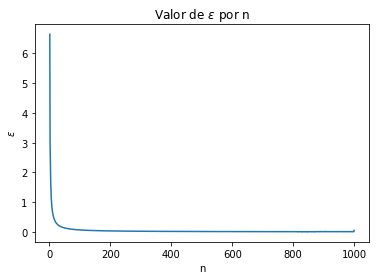

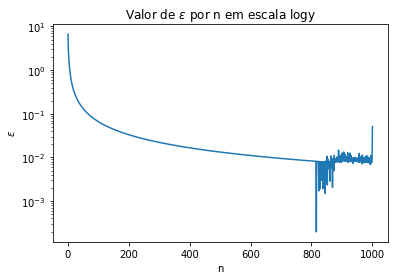

In [5]:
# Declaração de variáveis locais
n = 1000
m = 100
eps_vec = np.zeros(n)
p_bin = [.2, .8]
hp = entropy(p_bin)

# Laços de simulação n x m.
for ii in range(1, n+1):
    p_seq = np.power(2, -ii*hp)
    err_tmp = 0
    err_vec = np.zeros(m)
    for jj in range(m):
        # Cáluculo das grandezas estudadas para avaliação das métricas
        X_tmp = np.random.choice(2, size=ii, p=p_bin)
        num_1 = np.sum(X_tmp)
        num_0 = n - np.count_nonzero(X_tmp)
        p1_hat = num_1 / n
        p0_hat = 1 - p1_hat
        p_bin_hat = [p0_hat, p1_hat]
        pseq_hat = np.prod([p_bin_hat[idx] for idx in X_tmp])

        # Armazenamento das variáveis em vetores
        err_vec[jj] += np.abs(pseq_hat - p_seq) / m
    
    eps_vec[ii-1], _, _ = eps_calc(err_vec, hp, ii)  

# Plotagem dos valores de epsilon por comprimento de sequência
t_m = np.arange(1, n+1)
plt.plot(t_m, eps_vec)
plt.title(r"Valor de $\epsilon$ por n")
plt.xlabel("n")
plt.ylabel(r"$\epsilon$")
plt.show()

plt.plot(t_m, eps_vec)
plt.title(r"Valor de $\epsilon$ por n em escala logy")
plt.semilogy()
plt.xlabel("n")
plt.ylabel(r"$\epsilon$")
plt.show()